# Python Tutorial for Data Science
## Introduction to Machine Learning: Introduction to Model Training, Over/Underfitting, Validation 
#### Patrick Chao 1/21/18

# Introduction
The purpose of this notebook is to serve as an elementary python tutorial introducing fundamental data science concepts including data exploration, classification, hyper-parameter tuning, plotting, and loss functions. In this notebook, we will explore how to process and understand the data, create a model, tune, and test.

## How to Avoid Overfitting: Train/Validation/Test

A huge part of machine learning is ensuring that our model performs well. With current technology, we have access to massive datasets and information, but the difficulty is parsing through all the numbers to understand something. Models can require huge amounts of data and can take hours or days to train on the data to perform well. 

The first phase of training a model is, well, *training*.

### Training
In this part, the model continually learns on the data and improves. We use a subset of the data known as the **training set**. Given some model $f$, assume we have input $\vec{x}$ and a true label/output $\vec y$. We would like $f(\vec x)\approx \vec y$, or alternatively we would like to minimize $\|f(\vec x)-\vec y\|$. This value $\|f(\vec x)-\vec y\|$ is known as the **error** or **loss**, how close our model is to the correct value. When training on the training set, the error is more specifically known as the **training error**.

Our model looks through each training data instance and will have some prediction $f(\vec x)$. Based on the value of $\|f(\vec x)-\vec y\|$, the model will change slightly and improve. The more incorrect the prediction was, the more it will change. One method of optimizing our model $f$ is **gradient descent**. 

When training, the error follows this form of a curve.

<img src='train.png' width="400" height="400">

You may consider model order as the "complexity" of the model. This may be more parameters, higher dimensionality, or more training. As your model trains, the training error will continually decrease. An analogy would be predicting a line using a $10$ degree polynomial. Since any $10$ degree polynomial has linear degree terms, a $10$ degree polynomial should be at least as good as a linear model for the training data. However, we shall see that this may not always be the case for all data.

### Pitfalls of Training: Overfitting
One trap that models may run into is **overfitting**. This is where the model over-trained on the data and does not extrapolate to other real world examples. The model becomes overly complex and attempts to fit every nuance of the data, and fails to generalize. An analogy would be using a $10$ degree polynomial to fit a line. It may be able to fit the training data extremely well, better than a line would, but it may fail for other points.

The best way to understand this is an example.

Consider the polynomial $y=x^3-3x^2+4=(x+1)(x - 2)^2$. Assume that for a given value of $x$, the ground-truth value of $y$ is $x^3-3x^2+4$. We would like find a model $f(x)$ that predicts $y$ as best as possible. To do this, we will have some slightly perturbed input data from the range $-1$ to $7$, denoted by the dotted black lines. 

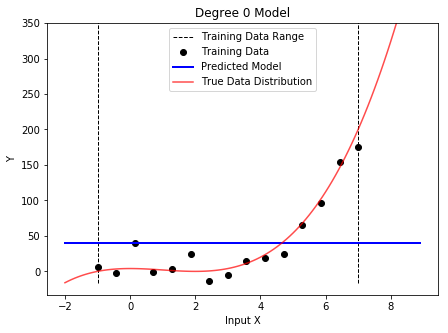

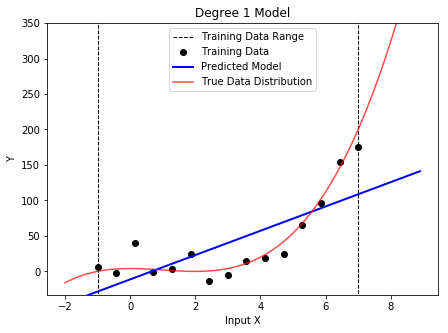

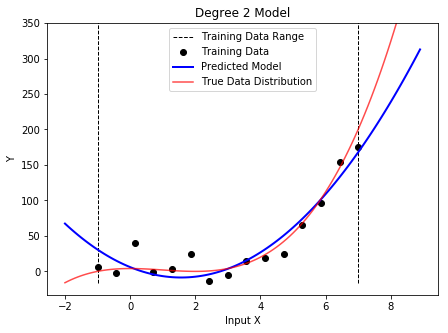

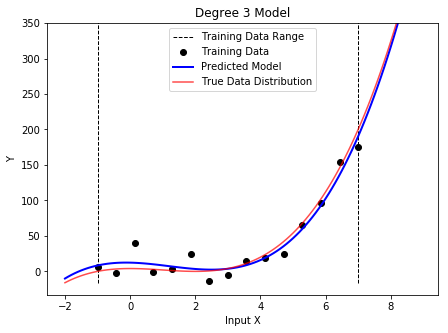

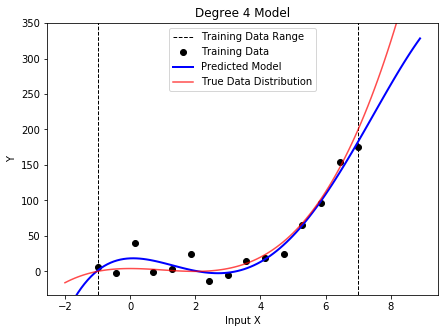

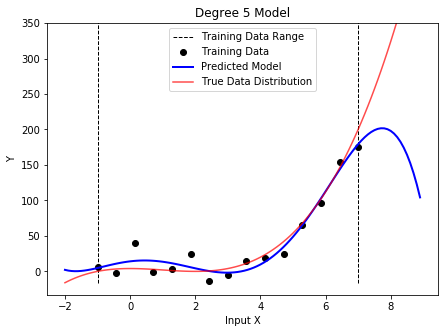

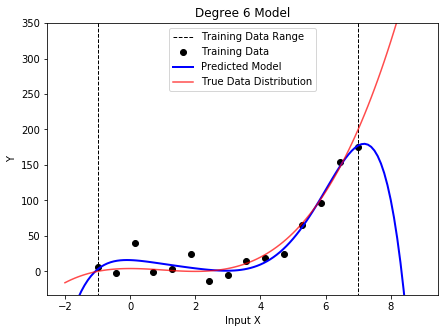

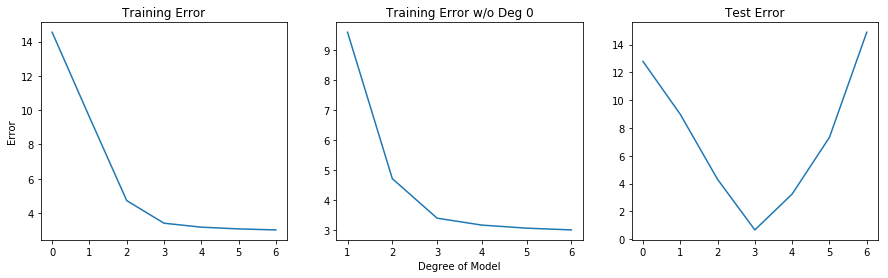

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
%matplotlib inline

np.random.seed(5)
trainDataRange = [-1,7]
trainDataRange = np.array(trainDataRange)

#Generate random training data within the trainDataRange
#Parameter for showing plots and number of samples
def generateTrainData(numSamples=15,showPlot=True):
    #Generate X data
    trainX = np.linspace(trainDataRange[0],trainDataRange[1],numSamples)
    trainX = np.sort(trainX)
    trueY = transform_x(trainX)
    #Add noise with variance 10
    noisyY = trueY+np.random.randn(numSamples)*15
    #Plot the data
    if showPlot:
        plt.plot(trainX,noisyY,'bo')
        plt.plot(trainDataRange, transform_x(trainDataRange), 'r-', lw=2)
        plt.ylabel("Noisy Y")
        plt.xlabel("Input X")
        plt.title("Clean X and Noisy Y from Linear Relationship")
        plt.ylim(ymin=min(noisyY-20),ymax=max(noisyY)*2)
        plt.show()
        plt.clf()
    return trainX,noisyY

def transform_x(inputX):
    return a*np.power(inputX,3)+b*np.power(inputX,2)+c*np.power(inputX,1)+d

#Validate the data on a larger range
#Default is -2 to 9
#Training region is denoted by dotted lines
def validate(model,trainX,noisyY,numSamples=500,dataRange=[-2,9],showPlot=True,coeffs={}):
    dataRange=np.arange(dataRange[0],dataRange[1],0.1)
    transformed_dataRange = transform_x(dataRange)
    #Generate x values from the data range
    inputX = np.random.random_sample((numSamples,))*(dataRange[-1]-dataRange[0])+dataRange[0]
    inputX = np.sort(inputX)
    trueY = transform_x(dataRange)
    predY=predict(model,dataRange)
    #Plot graphs
    if showPlot:
        #A bit of math to determine where to draw the dotted lines
        plt.figure(figsize = (7,5))
        coordX1 = [trainDataRange[0]]*2
        coordX2 = [trainDataRange[1]]*2
        minY = min(min(transformed_dataRange),min(predY))
        maxY = max(max(transformed_dataRange),max(predY))
        line1, = plt.plot(coordX1, [minY,maxY], 'k-', lw=1,linestyle="--", label="Training Data Range")
        plt.plot(coordX2, [minY,maxY], 'k-', lw=1,linestyle="--")
        #TrainX
        train, = plt.plot(trainX,noisyY,'ko', lw=2, label="Training Data")
        #Prediction
        pred, = plt.plot(dataRange,predY,'b-', lw=2, label="Predicted Model")
        #True Data
        trueData, = plt.plot(dataRange, transform_x(dataRange),'r-', lw=1.5, label="True Data Distribution",alpha=0.7)
        plt.ylabel("Y")
        plt.xlabel("Input X")
        plt.ylim(ymin=min(noisyY-20),ymax=max(noisyY)*2)
        title = "Degree " + str (len(model)-1)+ " Model"
        for i,key in enumerate(coeffs.keys()):
            title += " "+str(key)+"="+str(coeffs[key])
            if i<len(coeffs.keys())-1:
                title +=","
        plt.title(title)
        # Create a legend for the first line.
        legend = plt.legend(handles=[line1,train,pred,trueData])
        plt.show()
    return error(trueY,predY)

#Train the data
def model(trainX,trainY,degree=1):
    #Creates the vandermonde matrix https://en.wikipedia.org/wiki/Vandermonde_matrix
    powers=np.vander(trainX,degree+1)
    A=powers
    #Solves the normal equation
    model = np.linalg.solve(A.T@A,A.T@trainY)
    return model

#Predicts given x values based on a model
def predict(model,x):
    degree=len(model)-1
    powers=np.vander(x,degree+1)
    return powers@model

#Determines the error between true Y values and predicted
def error(trueY,predY):
    return np.linalg.norm((trueY-predY))/len(trueY)

#Generates graphs of different degree models
#Plots training error and test error
def overfittingDemo(maxDegree=6):
    trainX,trainY = generateTrainData(showPlot=False)
    trainError = []
    testError = []
    #Iterate over all model orders
    for deg in range(maxDegree+1):
        currModel = model(trainX,trainY,degree=deg)
        predTrainY = predict(currModel,trainX)
        currTrainErr = error(trainY,predTrainY)
        currTestErr = validate(currModel,trainX,trainY,showPlot=True)
        trainError.append(currTrainErr)
        testError.append(currTestErr)
    
    #Plot the errors
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(range(maxDegree+1),trainError)
    plt.ylabel("Error")
    plt.title("Training Error")
    
    plt.subplot(1,3,2)
    plt.plot(range(1,maxDegree+1),trainError[1:])
    plt.xlabel("Degree of Model")
    plt.title("Training Error w/o Deg 0")
    
    
    plt.subplot(1,3,3)
    plt.plot(range(maxDegree+1),testError)
    plt.title("Test Error")
    plt.show()
    # Uncomment if you are curious about the actual error values
    # print("Training Errors:",trainError)
    # print("Test Errors:",testError)
    

#True model: y=x^3-3x^2+4
a = 1
b = -3
c = 0
d = 4

overfittingDemo()


### Overfitting Continued

Hopefully from the demo, it is clear that the best model is the linear model. The other higher order polynomials obtain slightly lower training errors from about $0.4405$ to $0.4385$, a $.45\%$ decrease in training error. One might think that just obtaining the lowest training error is best, but from the test error, we find that this results in drastically worse test errors, from $0.077$ for a linear polynomial to $282.6$ for a degree $6$ polynomial, a huge decrease in performance.

Overfitting is shown in the graph below. On the y-axis is true error, some undeterminable quantity, and the x-axis is how complex our model is. 

<img src='trueError.png' width="400" height="400">

Another important note is **underfitting**! At the lefthand side of the graph, our model is not complex enough to properly grasp the data and does not perform well on the data. This may be seen through our degree $0$ model.

Overfitting and underfitting are major pitfalls in machine learning. It originally seems that we are doing great because our training error gets lower and lower, but we may have already crossed the threshold where we are overfitting to our data. How do we avoid this? 


### Validation
Our savior is validation! The essence of validation is to set aside some data, called **validation data** that we do not train on, and we find the error of our model on this validation data. Now using this as a form of "safety check", we can determine when our model begins to overfit and stop training there. There are many methods of implementing this validation data, such as initially setting aside $20\%$ of your data from the start to serve as validation. Another method is known as **k-fold cross-validation**. I will not go into it here, but it is relatively straight forward so I encourage anyone interested to read [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29). 

This is one form of ensuring that we do not overfit. Another largely used method is known as **regularization**. This is applying some kind of prior belief on our model. If we believe that our model should rely on only a small number of features of small magnitude, then coefficients of the form $(0,1.99,1.01)$ make more sense than $(-0.0165,5.47, -181)$. One method of regularization is **ridge regression**, where we add a penalty **$\lambda$** that essentially adds the magnitude of the weight vector as part of the loss function. In more mathematical terms, we add the weight vector as part of the penalization using the $\ell_2$ norm, meaning high weights have a quadratic penalty. This is a heavily used method of preventing overfitting as it does not necesarily require you to watch over the model. Just for kicks, try the ridge demo below! If you are curious about ridge regression and how it works, read [here!](https://en.wikipedia.org/wiki/Tikhonov_regularization)


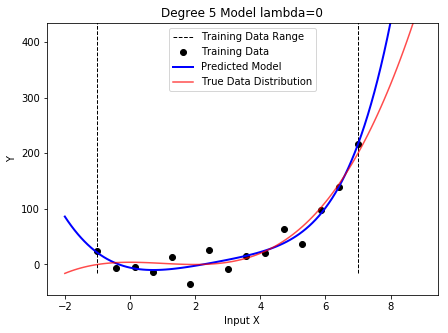

Training Error: 4.006
Test Error:  6.478
Coefficients: 0.015350, 0.126316, -2.352556, 11.392587, -12.939930, -5.654273


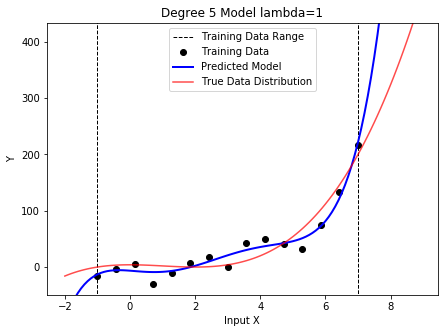

Training Error: 2.994
Test Error:  17.578
Coefficients: 0.156333, -1.864696, 6.492688, -2.417070, -4.381526, -6.476894


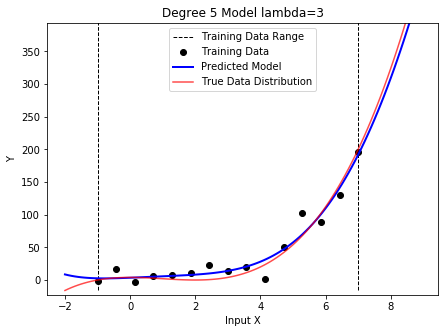

Training Error: 3.436
Test Error:  0.904
Coefficients: -0.008522, 0.193595, -0.495219, 0.454268, 2.042729, 3.512331


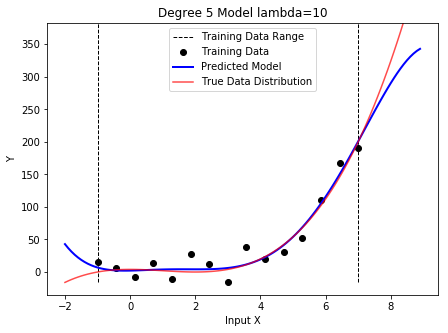

Training Error: 3.692
Test Error:  2.562
Coefficients: -0.043762, 0.691369, -2.506329, 2.578112, 1.052141, 2.128761


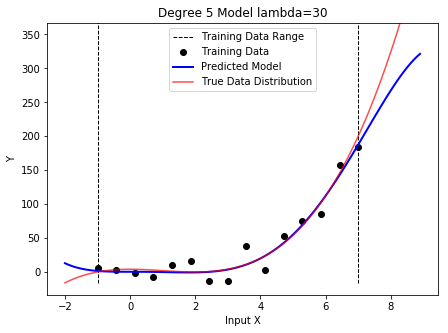

Training Error: 3.546
Test Error:  3.126
Coefficients: -0.025835, 0.363111, -0.729542, 0.005513, -0.063943, 0.279768


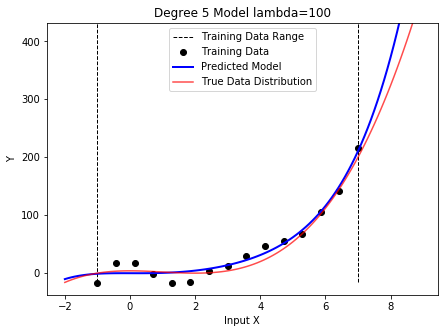

Training Error: 2.890
Test Error:  2.802
Coefficients: 0.018636, -0.167347, 0.882437, -0.047533, -0.150966, -0.099103


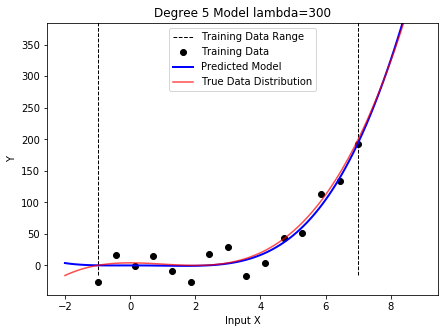

Training Error: 4.384
Test Error:  0.535
Coefficients: -0.007118, 0.170847, -0.238857, -0.284189, -0.018147, -0.054278


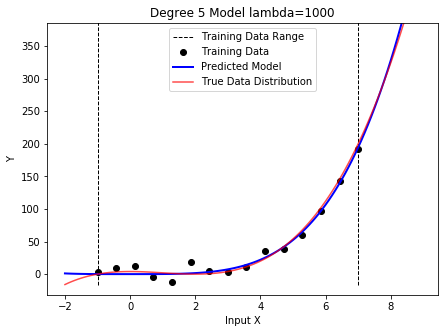

Training Error: 2.028
Test Error:  0.602
Coefficients: -0.000247, 0.077656, 0.032121, 0.022325, 0.000517, 0.022952


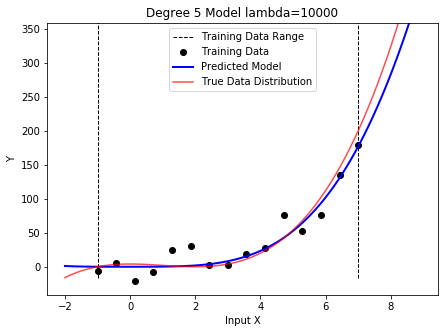

Training Error: 3.994
Test Error:  1.830
Coefficients: -0.003406, 0.088693, 0.057892, 0.025805, 0.011904, 0.003297


In [68]:
np.random.seed(1)

def ridgeDemo(lambdaCoeffs,maxDegree=5):
    for lambdaCoeff in lambdaCoeffs:
        trainX,trainY = generateTrainData(showPlot=False)
        currModel = ridgeModel(trainX,trainY,lambdaCoeff=lambdaCoeff,degree=maxDegree)
        predTrainY = predict(currModel,trainX)
        currTrainErr = error(trainY,predTrainY)
        currTestErr = validate(currModel,trainX,trainY,showPlot=True,coeffs={'lambda':lambdaCoeff})
        print("Training Error: %.3f"%(currTrainErr))
        print("Test Error:  %.3f"%(currTestErr))
        coeffs = "Coefficients: " 
        coeffs+=', '.join(['%-2f' for i in currModel])%tuple(currModel)
        print(coeffs)
    
def ridgeModel(trainX,trainY,lambdaCoeff,degree=10):
    powers=np.vander(trainX,degree+1)
    A=powers
    regularizationMatrix = lambdaCoeff*np.eye((A.shape[1]))
    model = np.linalg.solve(A.T@A+regularizationMatrix,A.T@trainY)
    return model

ridgeDemo(lambdaCoeffs = [0,1,3,10,30,100,300,1000,10000])

The above demo applies ridge regression with various values of $\lambda$ from $0$ to $10000$, for a fifth degree polynomial. The curve is still not a great prediction, but the parameters are incredibly small. The coefficients outputted represent the coefficients for $x^5$, $x^4$,... to $x^0$. For the $x^5$ term with just $\lambda=1$, the coefficient of $x^5$, $x^4$, $x^3$ are all less than $0.1$, and the test error is only $16.6$, significantly better than the $308$ from before. If there was some way to set the extremely small values to $0$, that would be fantastic! This is an alternative method that uses the $\ell_1$ error rather than $\ell_2$ error ([lasso](https://en.wikipedia.org/wiki/Lasso_(statistics%29)).



In [78]:
## Noise to Signal Demo
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<IPython.core.display.Javascript object>


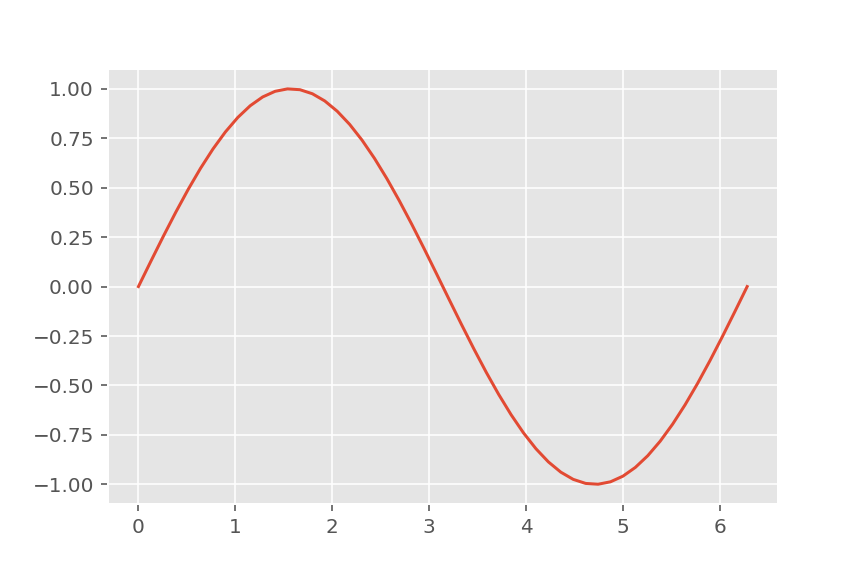

Widget Javascript not detected.  It may not be installed or enabled properly.


In [79]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw()

interact(update);